# Chapter 3 Examples

#### Example 3-0

In [ ]:
# Example 3-0. Import necessary libraries and set global variables.
# Import necessary libraries
from collections import Counter
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Errata: Change data and model storage paths
from src.config import data_dir, model_dir

# Set the random seed for reproducibility
seed = 1337
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

## The Perceptron: The Simplest Neural Network

#### Example 3-1

In [2]:
# Example 3-1. Implementing a perceptron using PyTorch
class Perceptron(nn.Module):
    """ A perceptron is one linear layer """
    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x_in):
        """The forward pass of the perceptron

        Args:
            x_in (torch.Tensor): an input data tensor
                x_in.shape should be (batch, num_features)
        Returns:
            the resulting tensor. tensor.shape should be (batch,).
        """
        return torch.sigmoid(self.fc1(x_in)).squeeze()

### Sigmoid

#### Example 3-2

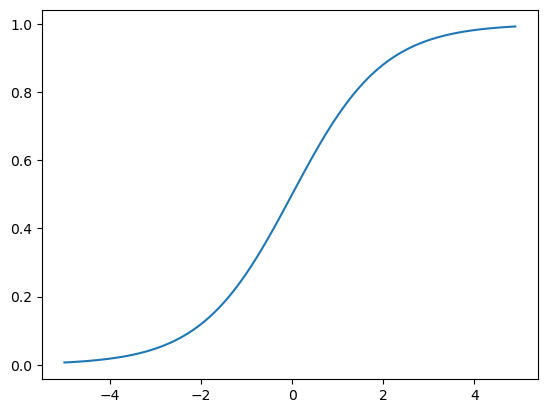

In [3]:
# Example 3-2. Sigmoid activation
# Errata: Updated `torch.range()` to `torch.arange()` due to deprecation
x = torch.arange(-5., 5., 0.1)
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

### Tanh

#### Example 3-3

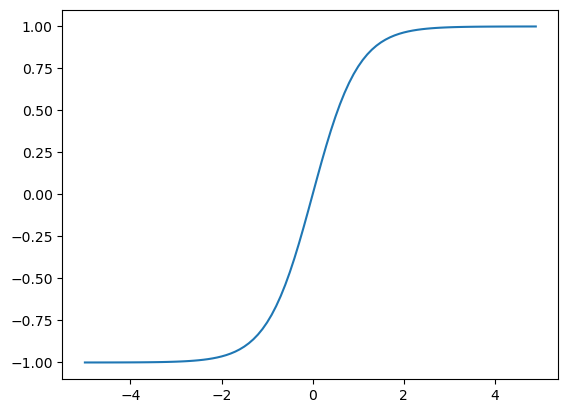

In [4]:
# Example 3-3. Tanh activation
# Errata: Updated `torch.range()` to `torch.arange()` due to deprecation
x = torch.arange(-5., 5., 0.1)
y = torch.tanh(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

### ReLU

#### Example 3-4

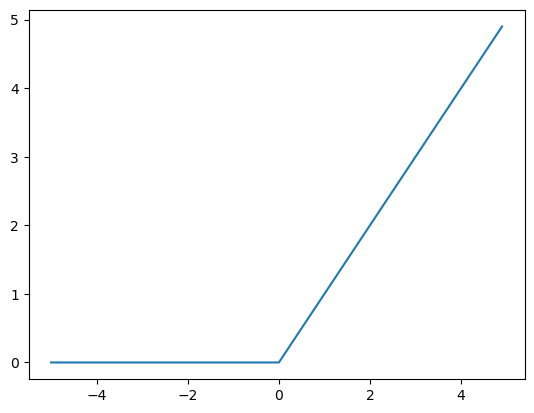

In [5]:
# Example 3-4. ReLU activation
relu = torch.nn.ReLU()
# Errata: Updated `torch.range()` to `torch.arange()` due to deprecation
x = torch.arange(-5., 5., 0.1)
y = relu(x)

plt.plot(x.numpy(), y.numpy())
plt.show()

#### Example 3-5

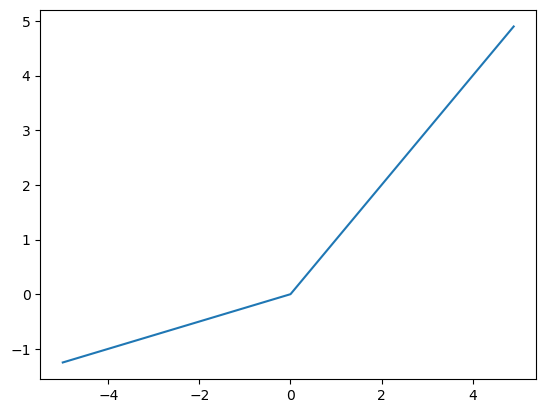

In [6]:
# Example 3-5. PReLU activation
prelu = torch.nn.PReLU(num_parameters=1)
# Errata: Updated `torch.range()` to `torch.arange()` due to deprecation
x = torch.arange(-5., 5., 0.1)
y = prelu(x)

# Errata: Added `detach()` to prevent backpropagation
plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

### Softmax

#### Example 3-6

In [7]:
# Example 3-6. Softmax activation
softmax = nn.Softmax(dim=1)
x_input = torch.randn(1, 3)
y_output = softmax(x_input)
print(x_input)
print(y_output)
print(torch.sum(y_output, dim=1))

tensor([[-2.0260, -2.0655, -1.2054]])
tensor([[0.2362, 0.2271, 0.5367]])
tensor([1.])


## Loss Functions

### Mean Squared Error Loss

#### Example 3-7

In [8]:
# Example 3-7. MSE loss
mse_loss = nn.MSELoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.randn(3, 5)
loss = mse_loss(outputs, targets)
print(loss)

tensor(1.6031, grad_fn=<MseLossBackward0>)


### Categorical Cross-Entropy Loss

#### Example 3-8

In [9]:
# Example 3-8. Cross-entropy loss
ce_loss = nn.CrossEntropyLoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.tensor([1, 0, 3], dtype=torch.int64)
loss = ce_loss(outputs, targets)
print(loss)

tensor(2.5949, grad_fn=<NllLossBackward0>)


### Binary Cross-Entropy Loss

#### Example 3-9

In [10]:
# Example 3-9. Binary cross-entropy loss
bce_loss = nn.BCELoss()
sigmoid = nn.Sigmoid()
probabilities = sigmoid(torch.randn(4, 1, requires_grad=True))
targets = torch.tensor([1, 0, 1, 0],  dtype=torch.float32).view(4, 1)
loss = bce_loss(probabilities, targets)
print(probabilities)
print(loss)

tensor([[0.7411],
        [0.5622],
        [0.8286],
        [0.6569]], grad_fn=<SigmoidBackward0>)
tensor(0.5958, grad_fn=<BinaryCrossEntropyBackward0>)


## Diving Deep into Supervised Training

#### Example 3-10

In [11]:
# Example 3-10. Instantiating the Adam optimizer
import torch.optim as optim

input_dim = 2
lr = 0.001

perceptron = Perceptron(input_dim=input_dim)
bce_loss = nn.BCELoss()
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)

#### Example 3-11

```python
# Example 3-11. A supervised training loop for a perceptron and binary classification
# each epoch is a complete pass over the training data
for epoch_i in range(n_epochs):
    # the inner loop is over the batches in the dataset
    for batch_i in range(n_batches):

        # Step 0: Get the data
        x_data, y_target = get_toy_data(batch_size)

        # Step 1: Clear the gradients
        perceptron.zero_grad()

        # Step 2: Compute the forward pass of the model
        y_pred = perceptron(x_data, apply_sigmoid=True)

        # Step 3: Compute the loss value that we wish to optimize
        loss = bce_loss(y_pred, y_target)

        # Step 4: Propagate the loss signal backward
        loss.backward()

        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()
```

## Auxiliary Training Concepts

### The Yelp Review Dataset

#### Example 3-12

```python
# Split the subset by rating to create new train, val, and test splits
by_rating = collections.defaultdict(list)
for _, row in review_subset.iterrows():
    by_rating[row.rating].append(row.to_dict())

# Create split data
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_rating.items()):
    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_val = int(args.val_proportion * n_total)
    n_test = int(args.test_proportion * n_total)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'

    for item in item_list[n_train+n_val:n_train+n_val+n_test]:
        item['split'] = 'test'

    # Add to final list
    final_list.extend(item_list)

final_reviews = pd.DataFrame(final_list)
```

#### Example 3-13

In [12]:
# Example 3-13. Minimally cleaning the data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

# final_reviews.review = final_reviews.review.apply(preprocess_text)

### Understanding PyTorch’s Dataset Representation

#### Example 3-14

In [13]:
# Example 3-14. A PyTorch Dataset class for the Yelp Review dataset
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch

        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        return cls(review_df, ReviewVectorizer.from_dataframe(review_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe

        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dict of the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset

        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

### Vocabulary

#### Example 3-15

In [14]:
# Example 3-15. The Vocabulary class maintains token to integer mapping needed for the rest of the machine learning pipeline
class Vocabulary(object):
    """Class to process text and extract Vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token

        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)


    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def lookup_token(self, token):
        """Retrieve the index associated with the token
          or the UNK index if token isn't present.

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
              for the UNK functionality
        """
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index

        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

### Vectorizer

#### Example 3-16

In [15]:
# Example 3-16. The Vectorizer class converts text to numeric vectors
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        """Create a collapsed one-hit vector for the review

        Args:
            review (str): the review
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)

        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)

        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1

        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate a ReviewVectorizer from a serializable dictionary

        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching

        Returns:
            contents (dict): the serializable dictionary
        """
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

### DataLoader

#### Example 3-17

In [16]:
# Example 3-17. Generating minibatches from a dataset
from torch.utils.data import DataLoader

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## A Perceptron Classifier

#### Example 3-18

In [17]:
# Example 3-18. A perceptron classifier for classifying Yelp reviews
class ReviewClassifier(nn.Module):
    """ a simple perceptron-based classifier """
    def __init__(self, num_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features,
                             out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor
                x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the cross-entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,).
        """
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = F.sigmoid(y_out)
        return y_out

### The Training Routine

#### Example 3-19

In [18]:
# Example 3-19. Hyperparameters and program options for the perceptron-based Yelp review classifier
from argparse import Namespace

args = Namespace(
    # Data and path information
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv=f'{data_dir}/yelp/reviews_with_splits_lite.csv',
    save_dir=f'{model_dir}/ch3/yelp/',
    vectorizer_file='vectorizer.json',
    # No model hyperparameters
    # Training hyperparameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    # Errata: Runtime options
    cuda=torch.cuda.is_available()  # Add the cuda attribute
)

### Setting the stage for the training to begin

#### Example 3-20

In [19]:
# Example 3-20. Instantiating the dataset, model, loss, optimizer, and training state
def make_train_state(args):
    return {'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1}
train_state = make_train_state(args)

if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

# dataset and vectorizer
dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
vectorizer = dataset.get_vectorizer()

# model
classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))
classifier = classifier.to(args.device)

# loss and optimizer
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

### The training loop

#### Example 3-21a

In [20]:
# Example 3-21a. Calculating the accuracy of predictions
def compute_accuracy(y_pred, y_target):
    """
    Calculate the accuracy of predictions.

    Args:
        y_pred (torch.Tensor): Predicted values (logits or probabilities).
        y_target (torch.Tensor): True labels.

    Returns:
        float: Accuracy score as a percentage.
    """
    # If y_pred is logits, apply a threshold (for binary classification)
    y_pred = torch.round(torch.sigmoid(y_pred))

    correct_predictions = (y_pred == y_target).float().sum()
    accuracy = correct_predictions / y_target.size(0)
    return accuracy.item() * 100


#### Example 3-21

In [21]:
# Example 3-21. A bare-bones training loop
for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index

    # Iterate over training dataset

    # setup: batch generator, set loss and acc to 0, set train mode on
    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        # the training routine is 5 steps:

        # step 1. zero the gradients
        optimizer.zero_grad()

        # step 2. compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()

        # -----------------------------------------
        # compute the accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    # Iterate over val dataset

    # setup: batch generator, set loss and acc to 0, set eval mode on
    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):

        # step 1. compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # step 2. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        # step 3. compute the accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

KeyboardInterrupt: 

## Evaluation, Inference, and Inspection

### Evaluating on test data

#### Example 3-22

In [ ]:
# Example 3-22. Test set evaluation
dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_batch = loss.item()
    running_loss += (loss_batch - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_batch - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [ ]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

### Inference and classifying new data points

#### Example 3-23

In [ ]:
# Example 3-23. Printing the prediction for a sample review
# Errata: Added import
import torch.nn.functional as F

# Errata: Added missing `device` argument to keep the tensors on the same device
def predict_rating(review, classifier, vectorizer, device=torch.device("cpu")):
    """
    Predict the rating for a given review.

    Args:
        review (str): The review text.
        classifier (torch.nn.Module): The trained classifier model.
        vectorizer (Vectorizer): The vectorizer used for preprocessing.
        device (torch.device): The device to run the prediction on (CPU or GPU).

    Returns:
        int: Predicted rating.
    """
    # Preprocess the review and vectorize
    review = preprocess_text(review)
    # Errata: Added missing `to(device)` to ensure the tensor is on the same device
    vectorized_review = torch.tensor(vectorizer.vectorize(review)).to(device)

    # Errata: Move model to the same device as the input
    classifier = classifier.to(device)

    # Perform prediction
    result = classifier(vectorized_review.view(1, -1))

    # Apply sigmoid to convert logits to probabilities
    probability_value = torch.sigmoid(result).item()

    # Convert to binary prediction (e.g., 1 if positive, else 0)
    index = 1 if probability_value >= 0.5 else 0

    return vectorizer.rating_vocab.lookup_index(index)


In [ ]:
test_review = "this is a pretty awesome book"
prediction = predict_rating(test_review, classifier, vectorizer)
# Errata: Fixed print statement
print(f"{test_review} -> {prediction}")

### Inspecting model weights

#### Example 3-24

In [ ]:
# Example 3-24. Inspecting what the classifier learned
# Sort weights
fc1_weights = classifier.fc1.weight.detach()[0]
_, indices = torch.sort(fc1_weights, dim=0, descending=True)
indices = indices.numpy().tolist()

# Top 20 words
print("Influential words in Positive Reviews:")
print("--------------------------------------")
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

In [ ]:
# Top 20 negative words
print("Influential words in Negative Reviews:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))